In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

2025-02-24 17:23:50.710341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 17:23:50.711063: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 17:23:50.716132: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 17:23:50.728100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740398030.751500    2585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740398030.75

## Dataset

In [3]:
dataset = tfds.load('imdb_reviews', as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print('Training Dataset Size:', len(train_dataset))
print('Test Dataset Size:', len(test_dataset))


Training Dataset Size: 25000
Test Dataset Size: 25000


2025-02-24 17:23:57.647145: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)
# train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
# test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
example, label = next(iter(train_dataset)) 
print('Text:\n', example.numpy()[0]) 
print('\nLabel: ', label.numpy()[0]) 

2025-02-24 17:23:58.031399: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Text:
 b'I remember going to see the movie in the summer of \'78 with my parents, and being pretty into it at the time. Of course, I was seven at the time.<br /><br />Right before the Jackson movies came out, my wife and I rented this movie since she had never seen it and I was feeling nostalgic.<br /><br />Ralph Bakshi ran out of money about mid-way through the animation process for this movie, and was forced to drastically cut corners on this production. Since this movie was done primarily with rotoscoping, the animation technique for people on a budget, this is saying something. Much of this movie is animation only in the very loosest sense of the word. There are some scenes which are very obviously just people standing in front of a screen, with maybe some animation effects superimposed on top of them.<br /><br />Because of budget constraints, the movie -- already a compression of "The Fellowship of the Rings" and part of "The Two Towers" -- was pared down even more. What you get i

2025-02-24 17:23:58.362406: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Text Vectorizatiom


In [6]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())

original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocab[encoded_text])

print('Original Text:\n', original_text)
print('\nEncoded Text:\n', encoded_text)
print('\nDecoded Text:\n', decoded_text)

2025-02-24 17:24:06.788096: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Original Text:
 b'I remember going to see the movie in the summer of \'78 with my parents, and being pretty into it at the time. Of course, I was seven at the time.<br /><br />Right before the Jackson movies came out, my wife and I rented this movie since she had never seen it and I was feeling nostalgic.<br /><br />Ralph Bakshi ran out of money about mid-way through the animation process for this movie, and was forced to drastically cut corners on this production. Since this movie was done primarily with rotoscoping, the animation technique for people on a budget, this is saying something. Much of this movie is animation only in the very loosest sense of the word. There are some scenes which are very obviously just people standing in front of a screen, with maybe some animation effects superimposed on top of them.<br /><br />Because of budget constraints, the movie -- already a compression of "The Fellowship of the Rings" and part of "The Two Towers" -- was pared down even more. What 

## Model Architecture

In [7]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.build(input_shape=[None, 1])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit( 
    train_dataset,  
    epochs=5, 
    validation_data=test_dataset, 
)

Epoch 1/5


2025-02-24 17:24:18.549795: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


782/782 ━━━━━━━━━━━━━━━━━━━━ 1162s 1s/step - accuracy: 0.7104 - loss: 0.5167 - val_accuracy: 0.7483 - val_loss: 0.4331
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1146s 1s/step - accuracy: 0.8671 - loss: 0.3054 - val_accuracy: 0.8735 - val_loss: 0.3233
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1127s 1s/step - accuracy: 0.9074 - loss: 0.2282 - val_accuracy: 0.8426 - val_loss: 0.3470
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1042s 1s/step - accuracy: 0.9421 - loss: 0.1467 - val_accuracy: 0.8629 - val_loss: 0.3306
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 581s 742ms/step - accuracy: 0.9681 - loss: 0.0944 - val_accuracy: 0.8645 - val_loss: 0.4024


In [9]:
model.evaluate(test_dataset)

782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 134ms/step - accuracy: 0.8607 - loss: 0.4137


[0.4023568034172058, 0.8645200133323669]

In [10]:
train_acc = model.evaluate(train_dataset,verbose=0)[1]
train_loss = model.evaluate(train_dataset,verbose=0)[0]
print('Training Accuracy:', train_acc)
print('Training Loss:', train_loss)

Training Accuracy: 0.985319972038269
Training Loss: 0.05355731025338173


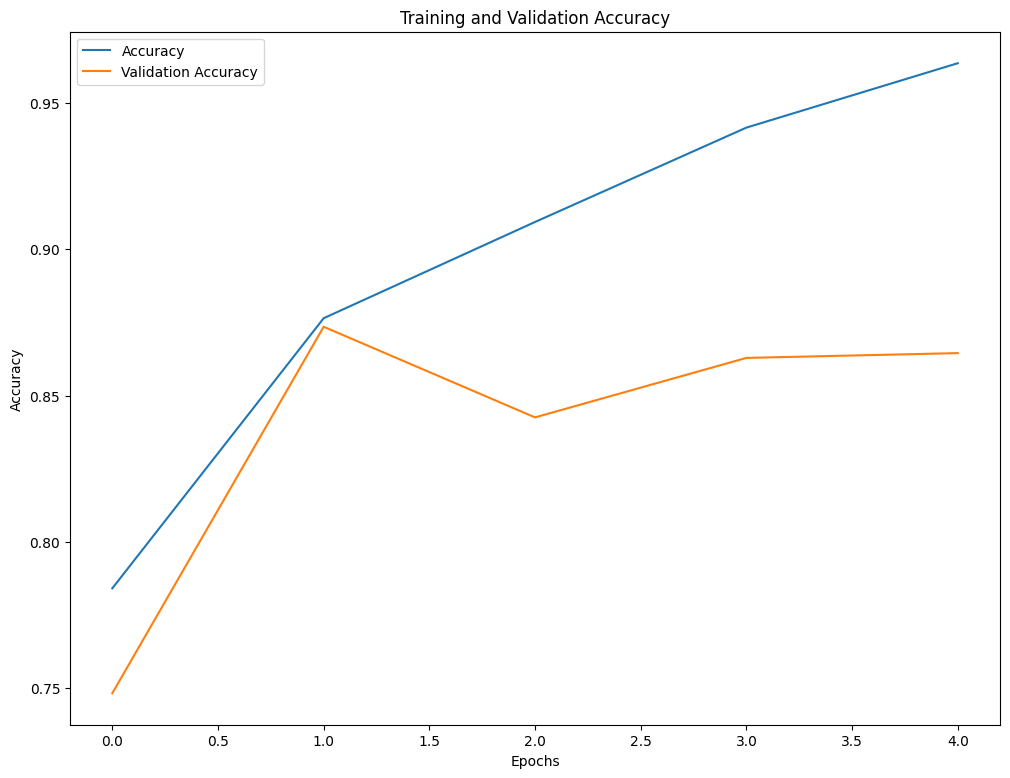

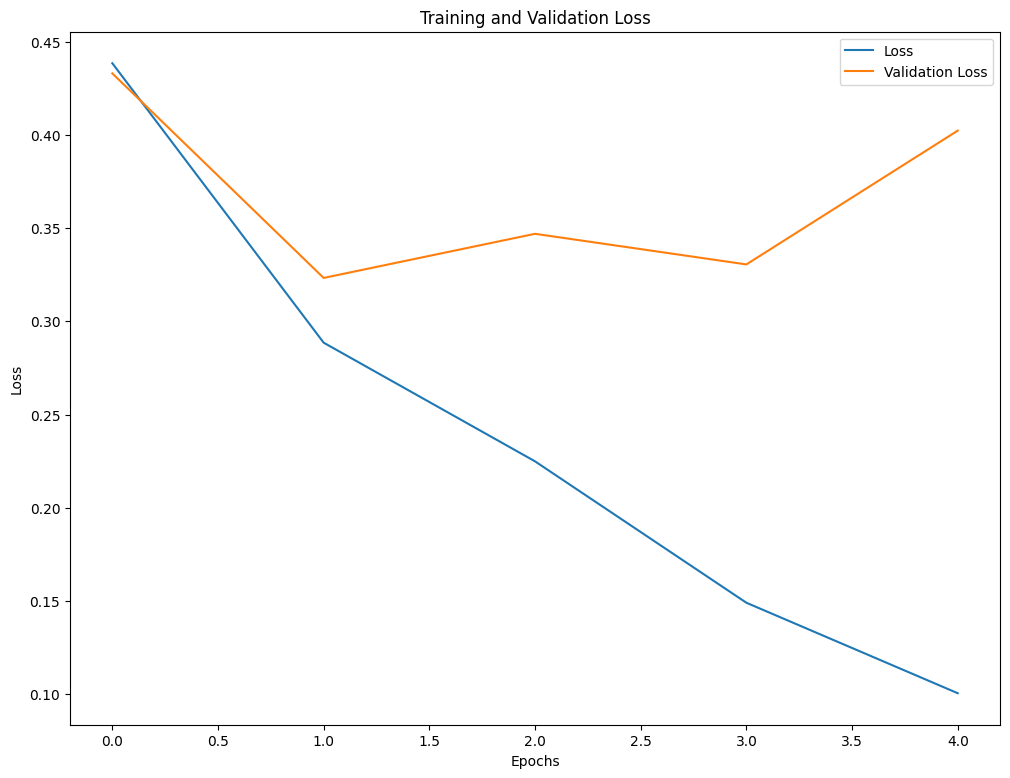

In [11]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(12, 9))
# plt.figure(figsize=(8, 4)) 
# plt.subplot(1, 2, 1) 
plt.plot(acc) 
plt.plot(val_acc) 
plt.title('Training and Validation Accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend(['Accuracy', 'Validation Accuracy']) 

plt.figure(figsize=(12, 9))  
# plt.subplot(1, 2, 2) 
plt.plot(loss) 
plt.plot(val_loss) 
plt.title('Training and Validation Loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend(['Loss', 'Validation Loss']) 
  
plt.show()

## Prediction

In [32]:
sample_text = ["yes"]
sample = tf.convert_to_tensor(sample_text)

predictions = model.predict(sample)

if predictions[0] > 0:
    print('The review is positive.')
else:
    print('The review is negative.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The review is positive.
